### Importing necessary libraries

In [ ]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset

### Creating a GPU device if available

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Creating the dataset and loading in the monkeys, defining transforms
- Composition of transforms (to tensor, grayscale)

tensor([[[0.1873, 0.1882, 0.1843,  ..., 0.2392, 0.2338, 0.2353],
         [0.1892, 0.1882, 0.1838,  ..., 0.2397, 0.2328, 0.2353],
         [0.1863, 0.1882, 0.1838,  ..., 0.2353, 0.2328, 0.2353],
         ...,
         [0.2049, 0.2265, 0.2578,  ..., 0.0941, 0.0971, 0.1118],
         [0.2377, 0.2642, 0.2892,  ..., 0.1157, 0.1309, 0.1525],
         [0.2603, 0.2721, 0.2946,  ..., 0.1544, 0.1784, 0.2005]]])


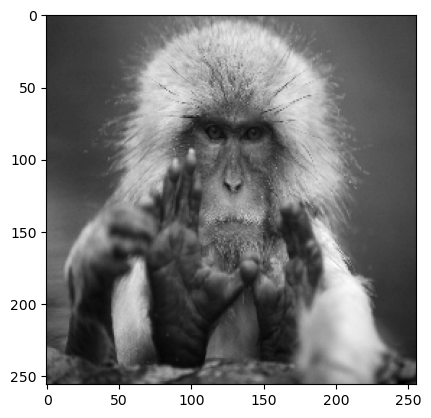

In [74]:
composed = transforms.Compose([
    transforms.Grayscale(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize([256, 256])  # Square images idea for CNN

])

class MonkeyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.number_samples = sum(self.img_labels.iloc[:, 3])  # 4th column, train images

        # Adding all monkeys to a list
        self.monkeys = []
        for dirname, _, filenames in os.walk(self.img_dir):
            for filename in filenames:
                self.monkeys.append((
                    os.path.join(dirname, filename),
                    filename
                ))

    def __getitem__(self, index):
        monkey_path, monkey_filename = self.monkeys[index]

        # Read monkey image from directory name
        monkey = read_image(monkey_path)

        # Get monkey label from filename
        label = monkey_filename[:2]  # Works since n0 to n9 all 2 characters
        
        # Apply the transforms:
        if self.transform:
            tmonkey = self.transform(monkey)
        
        return tmonkey, label

    def __len__(self):
        # This will allow len()
        return self.number_samples


'''
for dirname, _, filenames in os.walk('./kaggle/input'):
'''
# train_data = MonkeyDataset()
test_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/training/training",
    transform = composed
)
munke, tag = test_data[420]
print(munke)
plt.imshow(munke[0], cmap="gray")
# plt.show()

In [ ]:
e = pd.read_csv("./kaggle/input/10-monkey-species/monkey_labels.txt")
e.iloc[:,3]